# Initialize Spark Session and Read in Dataset

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [2]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
spark_version = 'spark-3.1.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [3]:
# Load in the Postgress Driver
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2021-11-18 01:22:21--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.2’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.31MB/s    in 0.7s    

2021-11-18 01:22:22 (1.31 MB/s) - ‘postgresql-42.2.9.jar.2’ saved [914037/914037]



In [4]:
# Import Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [5]:
# Store environmental variable
from getpass import getpass
password = getpass('finalproject99')
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://team5-stock-index-analysis.c5eoj6us86ug.us-east-2.rds.amazonaws.com:5432/postgres"
config = {"user":"postgres",
          "password": password,
          "driver":"org.postgresql.Driver"}

finalproject99··········


In [6]:
NYSE_df = spark.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "complete_join") \
    .option("user", "postgres") \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

NYSE_df.printSchema()

root
 |-- index: string (nullable = true)
 |-- date: string (nullable = true)
 |-- month: string (nullable = true)
 |-- quarter: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adj_close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- closeusd: double (nullable = true)
 |-- observation_date: string (nullable = true)
 |-- lfwa64ttusm647s: double (nullable = true)
 |-- gdpc1: double (nullable = true)
 |-- location: string (nullable = true)
 |-- indicator: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- measure: string (nullable = true)
 |-- frequency: string (nullable = true)
 |-- value: double (nullable = true)



In [7]:
NYSE_df.show()

+-----+--------+-------+-------+----------+----------+----------+----------+----------+------+----------+----------------+---------------+--------+--------+---------+-------+-------+---------+--------+
|index|    date|  month|quarter|      open|      high|       low|     close| adj_close|volume|  closeusd|observation_date|lfwa64ttusm647s|   gdpc1|location|indicator|subject|measure|frequency|   value|
+-----+--------+-------+-------+----------+----------+----------+----------+----------+------+----------+----------------+---------------+--------+--------+---------+-------+-------+---------+--------+
|  NYA|12/31/65|1965-12|1965-Q4|528.690002|528.690002|528.690002|528.690002|528.690002|   0.0|528.690002|      1965-12-01|       7.7178E7|4304.731|     USA|      CPI|    TOT|IDX2015|        M|13.41676|
|  NYA|  1/3/66| 1966-1|1966-Q1|527.210022|527.210022|527.210022|527.210022|527.210022|   0.0|527.210022|      1966-01-01|       7.7178E7|4409.518|     USA|      CPI|    TOT|IDX2015|        M|

# Data Pre-processing 

In [8]:
#Convert SparkDataFrame to Pandas DataFrame
NYSE_pdf = NYSE_df.toPandas()
NYSE_pdf

,index,date,month,quarter,open,high,low,close,adj_close,volume,closeusd,observation_date,lfwa64ttusm647s,gdpc1,location,indicator,subject,measure,frequency,value
0,NYA,12/31/65,1965-12,1965-Q4,528.690002,528.690002,528.690002,528.690002,528.690002,0.000000e+00,528.690002,1965-12-01,7.717800e+07,4304.731,USA,CPI,TOT,IDX2015,M,13.41676
1,NYA,1/3/66,1966-1,1966-Q1,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000e+00,527.210022,1966-01-01,7.717800e+07,4409.518,USA,CPI,TOT,IDX2015,M,13.41676
2,NYA,1/4/66,1966-1,1966-Q1,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000e+00,527.840027,1966-01-01,7.717800e+07,4409.518,USA,CPI,TOT,IDX2015,M,13.41676
3,NYA,1/5/66,1966-1,1966-Q1,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000e+00,531.119995,1966-01-01,7.717800e+07,4409.518,USA,CPI,TOT,IDX2015,M,13.41676
4,NYA,1/6/66,1966-1,1966-Q1,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000e+00,532.070007,1966-01-01,7.717800e+07,4409.518,USA,CPI,TOT,IDX2015,M,13.41676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13942,NYA,5/24/21,2021-5,2021-Q4,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09,16464.689450,2021-05-01,2.058753e+08,NaN,USA,CPI,TOT,IDX2015,M,113.57620
13943,NYA,5/25/21,2021-5,2021-Q4,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09,16390.189450,2021-05-01,2.058753e+08,NaN,USA,CPI,TOT,IDX2015,M,113.57620
13944,NYA,5/26/21,2021-5,2021-Q4,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09,16451.960940,2021-05-01,2.058753e+08,NaN,USA,CPI,TOT,IDX2015,M,113.57620
13945,NYA,5/27/21,2021-5,2021-Q4,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220,5.201110e+09,16531.949220,2021-05-01,2.058753e+08,NaN,USA,CPI,TOT,IDX2015,M,113.57620


In [9]:
NYSE_pdf.head(10)
print(NYSE_pdf.count())

index               13947
date                13947
month               13947
quarter             13947
open                13947
high                13947
low                 13947
close               13947
adj_close           13947
volume              13947
closeusd            13947
observation_date    13947
lfwa64ttusm647s     13947
gdpc1               13885
location            13947
indicator           13947
subject             13947
measure             13947
frequency           13947
value               13947
dtype: int64


In [10]:
# Column Types
NYSE_pdf.dtypes

index                object
date                 object
month                object
quarter              object
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume              float64
closeusd            float64
observation_date     object
lfwa64ttusm647s     float64
gdpc1               float64
location             object
indicator            object
subject              object
measure              object
frequency            object
value               float64
dtype: object

In [11]:
# Drop null and unnecessary columns
NYSE_pdf = NYSE_pdf.drop(columns=['date','index','month','quarter','open','high','low','close','adj_close','volume','location','indicator','subject','measure','frequency', 'observation_date'])
# Drop blank rows
NYSE_pdf = NYSE_pdf.dropna()

In [12]:
# Rename Columns
NYSE_pdf = NYSE_pdf.rename(columns={'closeusd':'NYA_Close_Price','value':'Inflation','gdpc1':'Real_GDP','lfwa64ttusm647s':'Working_Pop'})


In [13]:
NYSE_pdf.head()

,NYA_Close_Price,Working_Pop,Real_GDP,Inflation
0,528.690002,77178000.0,4304.731,13.41676
1,527.210022,77178000.0,4409.518,13.41676
2,527.840027,77178000.0,4409.518,13.41676
3,531.119995,77178000.0,4409.518,13.41676
4,532.070007,77178000.0,4409.518,13.41676


In [14]:
# Divide Inflation by 100
NYSE_pdf['Inflation'] = NYSE_pdf['Inflation'] / 100

# Real GDP * 1B
NYSE_pdf['Real_GDP'] = NYSE_pdf['Real_GDP'] * 1000000000

# Calculate Real GDP per Capita from GDP and Population
NYSE_pdf['Real_GDP_per_Capita'] = NYSE_pdf['Real_GDP'] / NYSE_pdf['Working_Pop']

# Drop Real_GDP column
NYSE_pdf = NYSE_pdf.drop(columns=['Real_GDP'])


In [15]:
NYSE_pdf.head()

,NYA_Close_Price,Working_Pop,Inflation,Real_GDP_per_Capita
0,528.690002,77178000.0,0.134168,55776.659152
1,527.210022,77178000.0,0.134168,57134.390629
2,527.840027,77178000.0,0.134168,57134.390629
3,531.119995,77178000.0,0.134168,57134.390629
4,532.070007,77178000.0,0.134168,57134.390629


# Split Data into Training and Testing

In [16]:
# Create our features
X = NYSE_pdf.drop('NYA_Close_Price', axis=1)

# Create our target
y = NYSE_pdf['NYA_Close_Price']

X.head()

,Working_Pop,Inflation,Real_GDP_per_Capita
0,77178000.0,0.134168,55776.659152
1,77178000.0,0.134168,57134.390629
2,77178000.0,0.134168,57134.390629
3,77178000.0,0.134168,57134.390629
4,77178000.0,0.134168,57134.390629


In [17]:
# Check features
X.describe()

,Working_Pop,Inflation,Real_GDP_per_Capita
count,1.388500e+04,13885.000000,13885.000000
mean,1.581231e+08,0.598370,66888.083592
std,4.084326e+07,0.301161,13151.200150
min,7.717800e+07,0.134168,44983.721611
25%,1.418840e+08,0.320230,58116.212472
50%,1.643504e+08,0.610927,62957.293497
75%,1.954066e+08,0.877224,78460.855045
max,2.073116e+08,1.126729,94220.229869


In [18]:
# Check the balance of our target values
y.value_counts()

569.919983     11
586.630005      9
555.020020      8
567.599976      8
555.119995      7
               ..
2697.360107     1
2540.229980     1
2603.989990     1
3753.250000     1
6862.310059     1
Name: NYA_Close_Price, Length: 11528, dtype: int64

In [19]:
# Split into training and testing 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=1
                                                )

In [20]:
# Initialize the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [21]:
# Train the data
model.fit(X_train, y_train)

LinearRegression()

# Determine the equation for the Multiple Variable Linear Regression

In [22]:
#Find the y-intercept and coefficients
model.intercept_
coef = model.coef_

print("The intercept for our model is %.2f" % model.intercept_)
print('-'*100)

#Loop through coefficients and print data
for cf in zip(X.columns, coef):
    print ("The coefficient for {} is {:.5}".format(cf[0],cf[1]))

The intercept for our model is -13234.04
----------------------------------------------------------------------------------------------------
The coefficient for Working_Pop is 1.8474e-05
The coefficient for Inflation is 2653.9
The coefficient for Real_GDP_per_Capita is 0.19632


**Pred Close Price = 2653.9 x Pred Inflation + 0.19632 x Pred Real GDP per Capita + 0.000018474 x Pred Working Pop - 13234.04**

Using this formula, we can predict closing NYSE prices based on predicted values for inflation, Real GDP per Capita and working population.

# Evaluating the Model through Metrics

In [23]:
# Calculate the model accuracy score (1 is perfect prediction)
from sklearn.metrics import r2_score, mean_squared_error

#, X_test[Working_Pop],X_test[Real_GDP_per_Capita])
y_pred = model.predict(X_test)

#Calculate the coefficient of determination, or r2_score. The r2_score is a measure of accuracy for linear regression models.
r2_score = r2_score(y_test, y_pred)
print(f'Coefficient of determination: {r2_score*100:.2f} %')

Coefficient of determination: 94.57 %


In [24]:
#Calculate the model score.
print(f'Model Score: {model.score(X_test, y_test)*100: .2f} %')

Model Score:  94.57 %


In [25]:
# Calculate the root mean squared error. This is a measure of how close the points are to a best fit line.
print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared=False))

Root mean squared error: 929.69


Text(0, 0.5, 'Predicted (y_pred)')

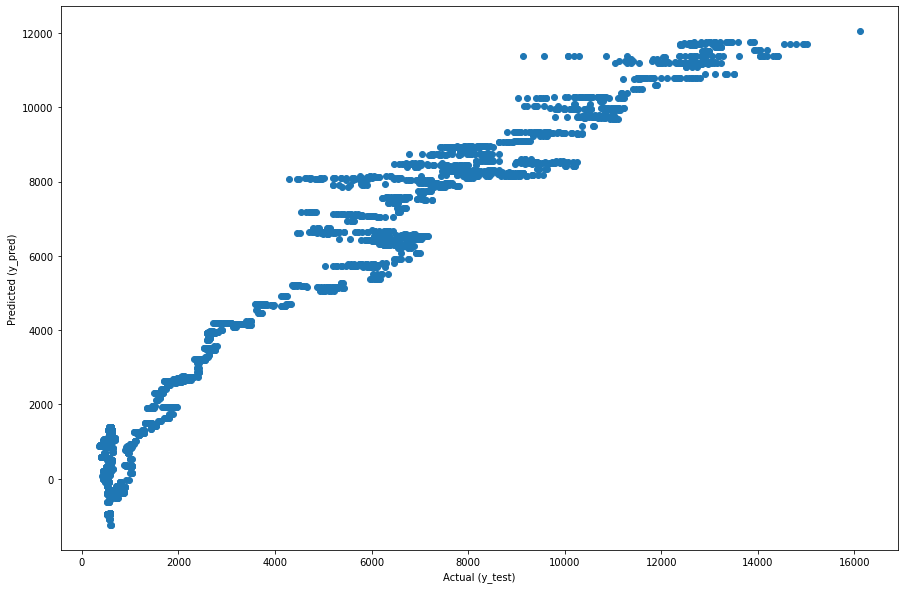

In [26]:
# Plot y_pred v y_test. This shows how closely the model predicted the y values using the equation (y_pred) compared to the actual y values (y_test).
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual (y_test)')
plt.ylabel('Predicted (y_pred)')

In [27]:
pred_y_df=pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'Difference': y_test-y_pred, 'Percent Difference': (y_test-y_pred)/y_pred *100})
pred_y_df.head(20)

,y_test,y_pred,Difference,Percent Difference
5945,2059.659912,2629.408783,-569.748871,-21.668326
6682,2394.949951,3111.671372,-716.721421,-23.033326
2913,560.830017,-956.603067,1517.433084,-158.627244
12427,11227.889650,9986.871319,1241.018331,12.426498
5329,1790.869995,1928.697305,-137.827310,-7.146135
3929,735.400024,-185.960154,921.360178,-495.461074
8892,6654.680176,6526.618800,128.061376,1.962140
1644,649.229980,1035.503527,-386.273547,-37.302968
10949,5775.240234,7938.868081,-2163.627847,-27.253606
7653,3790.050049,4696.207235,-906.157186,-19.295511


# Predict Future closing prices

In [28]:
# Upload Predict_df
from pyspark import SparkFiles
url = "https://team5-stock-index-bucket.s3.us-east-2.amazonaws.com/final+project+data/Predict_df.csv"
spark.sparkContext.addFile(url)
Predict_df = spark.read.csv(SparkFiles.get("Predict_df.csv"), sep=",", header=True, inferSchema=True)
Predict_df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- lfwa64ttusm647s: double (nullable = true)
 |-- value: double (nullable = true)
 |-- gdpc1: double (nullable = true)



In [29]:
Predict_df.show()

+--------+---------------+--------+-------+
|    Date|lfwa64ttusm647s|   value|  gdpc1|
+--------+---------------+--------+-------+
|12/31/65|       7.7178E7|13.41676|4304.73|
|  1/3/66|       7.7178E7|13.41676|4409.52|
|  1/4/66|       7.7178E7|13.41676|4409.52|
|  1/5/66|       7.7178E7|13.41676|4409.52|
|  1/6/66|       7.7178E7|13.41676|4409.52|
|  1/7/66|       7.7178E7|13.41676|4409.52|
| 1/10/66|       7.7178E7|13.41676|4409.52|
| 1/11/66|       7.7178E7|13.41676|4409.52|
| 1/12/66|       7.7178E7|13.41676|4409.52|
| 1/13/66|       7.7178E7|13.41676|4409.52|
| 1/14/66|       7.7178E7|13.41676|4409.52|
| 1/17/66|       7.7178E7|13.41676|4409.52|
| 1/18/66|       7.7178E7|13.41676|4409.52|
| 1/19/66|       7.7178E7|13.41676|4409.52|
| 1/20/66|       7.7178E7|13.41676|4409.52|
| 1/21/66|       7.7178E7|13.41676|4409.52|
| 1/24/66|       7.7178E7|13.41676|4409.52|
| 1/25/66|       7.7178E7|13.41676|4409.52|
| 1/26/66|       7.7178E7|13.41676|4409.52|
| 1/27/66|       7.7178E7|13.416

In [30]:
#Convert SparkDataFrame to Pandas DataFrame
Predict_pdf = Predict_df.toPandas()
Predict_pdf

,Date,lfwa64ttusm647s,value,gdpc1
0,12/31/65,77178000.0,13.416760,4304.73
1,1/3/66,77178000.0,13.416760,4409.52
2,1/4/66,77178000.0,13.416760,4409.52
3,1/5/66,77178000.0,13.416760,4409.52
4,1/6/66,77178000.0,13.416760,4409.52
...,...,...,...,...
17446,12/27/30,223500253.6,142.428652,22309.05
17447,12/28/30,223500253.6,142.428652,22309.05
17448,12/29/30,223500253.6,142.428652,22309.05
17449,12/30/30,223500253.6,142.428652,22309.05


In [31]:
#Preprocess
Predict_pdf = Predict_df.toPandas()
# Rename Columns
Predict_pdf = Predict_pdf.rename(columns={'closeusd':'NYA_Close_Price','value':'Inflation','gdpc1':'Real_GDP','lfwa64ttusm647s':'Working_Pop'})

# Divide Inflation by 100
Predict_pdf['Inflation'] = Predict_pdf['Inflation'] / 100

# Real GDP * 1B
Predict_pdf['Real_GDP'] = Predict_pdf['Real_GDP'] * 1000000000

# Calculate Real GDP per Capita from GDP and Population
Predict_pdf['Real_GDP_per_Capita'] = Predict_pdf['Real_GDP'] / Predict_pdf['Working_Pop']

# Drop Real_GDP column
Predict_pdf = Predict_pdf.drop(columns=['Real_GDP'])

Predict_pdf.set_index('Date', inplace=True)

Predict_pdf.head()

,Working_Pop,Inflation,Real_GDP_per_Capita
Date,,,
12/31/65,77178000.0,0.134168,55776.646195
1/3/66,77178000.0,0.134168,57134.416544
1/4/66,77178000.0,0.134168,57134.416544
1/5/66,77178000.0,0.134168,57134.416544
1/6/66,77178000.0,0.134168,57134.416544


In [32]:
Predict_pdf.describe()

,Working_Pop,Inflation,Real_GDP_per_Capita
count,1.745100e+04,17451.000000,17451.000000
mean,1.694936e+08,0.737655,72710.487080
std,4.286059e+07,0.386222,16938.049874
min,7.717800e+07,0.134168,44850.672940
25%,1.481958e+08,0.418535,58697.758621
50%,1.794295e+08,0.729062,73198.658157
75%,2.055282e+08,1.041356,88953.902781
max,2.235003e+08,1.424287,100680.175854


In [33]:
Projection = model.predict(Predict_pdf)
Projection

array([ -502.12744709,  -235.57064885,  -235.57064885, ...,
       14270.81880439, 14270.81880439, 14270.81880439])

In [34]:
Projection_export = pd.DataFrame(Projection, 
             columns=['Pred_close_price'])
Projection_export

,Pred_close_price
0,-502.127447
1,-235.570649
2,-235.570649
3,-235.570649
4,-235.570649
...,...
17446,14270.818804
17447,14270.818804
17448,14270.818804
17449,14270.818804


In [35]:
Projection_export.to_excel("/content/Projection.xlsx")